In [1]:
# !nvidia-smi -L # Tesla K80
!git clone https://github.com/NVlabs/stylegan3
%cd /content/stylegan3
!pip install Ninja


Cloning into 'stylegan3'...
remote: Enumerating objects: 193, done.
remote: Total 193 (delta 0), reused 0 (delta 0), pack-reused 193
Receiving objects: 100% (193/193), 4.18 MiB | 15.72 MiB/s, done.
Resolving deltas: 100% (86/86), done.
/content/stylegan3


In [47]:

import os
import re
import dnnlib
import numpy as np
import PIL.Image
import torch
import legacy

device = torch.device('cuda')
# https://api.ngc.nvidia.com/v2/models/nvidia/research/stylegan3/versions/1/files/
# network_pkl='https://api.ngc.nvidia.com/v2/models/nvidia/research/stylegan3/versions/1/files/stylegan3-t-ffhqu-256x256.pkl' # smile hard
# network_pkl='https://api.ngc.nvidia.com/v2/models/nvidia/research/stylegan3/versions/1/files/stylegan3-t-ffhq-1024x1024.pkl' #ok?
# network_pkl='https://api.ngc.nvidia.com/v2/models/nvidia/research/stylegan3/versions/1/files/stylegan3-r-ffhqu-256x256.pkl' #crop chin
# network_pkl='https://api.ngc.nvidia.com/v2/models/nvidia/research/stylegan3/versions/1/files/stylegan3-r-ffhq-1024x1024.pkl' #face left
network_pkl='https://api.ngc.nvidia.com/v2/models/nvidia/research/stylegan3/versions/1/files/stylegan3-r-metfaces-1024x1024.pkl' #monet?

with dnnlib.util.open_url(network_pkl) as f:
    G = legacy.load_network_pkl(f)['G_ema'].to(device) # type: ignore

def generate_images(z):
    label = torch.zeros([1, G.c_dim], device=device)
    # Construct an inverse rotation/translation matrix and pass to the generator. The generator expects this matrix as an inverse to avoid potentially failing numerical operations in the network.
    if hasattr(G.synthesis, 'input'):
        # m = make_transform(translate=(0,0), rotate=0)
        m = np.eye(3)
        m = np.linalg.inv(m)
        G.synthesis.input.transform.copy_(torch.from_numpy(m))
    img = G(z, label, truncation_psi=1, noise_mode='none') # noise_mode 'const', 'random', 'none'
    img = (img.permute(0, 2, 3, 1) * 127.5 + 128).clamp(0, 255).to(torch.uint8)
    # PIL.Image.fromarray(img[0].cpu().numpy(), 'RGB').save(f'{outdir}/seed{seed:04d}.png') # 'out'
    imgs=PIL.Image.fromarray(img[0].cpu().numpy(), 'RGB')
    return imgs

def createImageGrid(image):
    canvas = PIL.Image.new('RGBA', image.size, 'white')
    canvas.paste(image)
    return canvas

# z = torch.from_numpy(np.random.RandomState(1).randn(1, G.z_dim)).to(device)


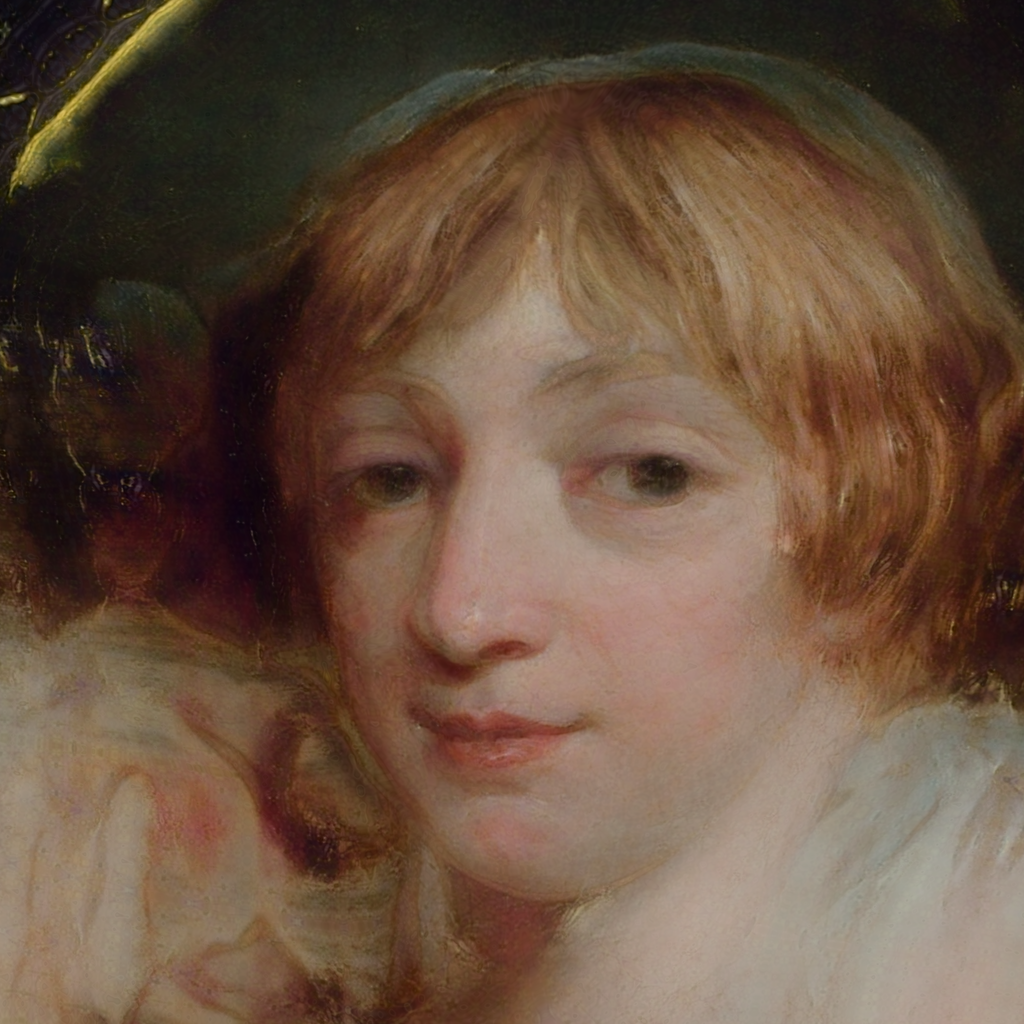

In [50]:


z = torch.from_numpy(np.random.rand(1, G.z_dim)).to(device) # Size([1, 512])
# print(G)
img1=generate_images(z)
display(createImageGrid(img1))

